In [1]:
import torch
import onnx
import onnxruntime as ort
import numpy as np
from tqdm.auto import tqdm
import json
from numpyencoder import NumpyEncoder

In [2]:
# Global Configs

DELTA = 0.99
NET_PATH = "./mnist-net_256x4.onnx"
DATA = torch.load("./dataset/training.pt")
LAYERS = 4
EXPT_NAME = "256x4_global_heatmap"

In [3]:
# Data preprocessing

imgs = torch.load("./dataset/normalized_train.pt")
imgs = imgs.reshape(60000, 1, 784, 1).numpy()

In [4]:
# Modifying model to get neuron activations

model = onnx.load(NET_PATH)

def add_intermediate_outputs(model):
    graph = model.graph
    for node in graph.node:
        if node.op_type == "Relu":
            for output in node.output:
                intermediate_value_info = onnx.helper.make_tensor_value_info(output, onnx.TensorProto.FLOAT, None)
                graph.output.append(intermediate_value_info)
    return model

modified_model = add_intermediate_outputs(model)

modified_model_path = f'{NET_PATH.split(".")[1][1:]}_modified.onnx'
onnx.save(modified_model, modified_model_path)


In [5]:
# Setting up inference in onnx

session = ort.InferenceSession(modified_model_path)
input_name = session.get_inputs()[0].name

In [14]:
# Going through each label
P = {
    'config':
    {
        'net': NET_PATH,
        'delta': DELTA,
        'data_len': DATA[1].shape[0]
    }
}

for label in range(10):
    # Filetering relevant data alone
    mask = (DATA[1] == label).numpy()
    S = imgs[mask]

    # Initializing a counter
    count = np.zeros((LAYERS, 256))

    # Counting across relevant data
    print(f"Processing label {label}...")

    for example in tqdm(S):
        outputs = session.run(None, {input_name: example})
        neuron_activations = np.concatenate(outputs[1:])
        whether_activated = neuron_activations > 0
        count += whether_activated

    # Adding neuron indices in A or D based on whether their fr (frequency ratio) is greater than or lesser than delta
    fr = count / S.shape[0]
    greater_than_delta = np.where(fr>=DELTA)
    lesser_than_delta = np.where(fr<(1-DELTA))
    A = list(zip(greater_than_delta[0], greater_than_delta[1]))
    D = list(zip(lesser_than_delta[0], lesser_than_delta[1]))
    
    P[label] = {
        "A":
        {
            "len": len(A),
            "indices": A
        },
        "D": {
            "len": len(D),
            "indices": D
        }
    }

Processing label 0...


  0%|          | 0/5923 [00:00<?, ?it/s]

Processing label 1...


  0%|          | 0/6742 [00:00<?, ?it/s]

Processing label 2...


  0%|          | 0/5958 [00:00<?, ?it/s]

Processing label 3...


  0%|          | 0/6131 [00:00<?, ?it/s]

Processing label 4...


  0%|          | 0/5842 [00:00<?, ?it/s]

Processing label 5...


  0%|          | 0/5421 [00:00<?, ?it/s]

Processing label 6...


  0%|          | 0/5918 [00:00<?, ?it/s]

Processing label 7...


  0%|          | 0/6265 [00:00<?, ?it/s]

Processing label 8...


  0%|          | 0/5851 [00:00<?, ?it/s]

Processing label 9...


  0%|          | 0/5949 [00:00<?, ?it/s]

In [15]:
# Writing it out into a file

with open(f"./NAPs/{EXPT_NAME}.json", "w") as f:
    json.dump(P, f, cls=NumpyEncoder)

In [7]:
# Getting global heatmap

global_count = np.zeros((LAYERS, 256))

for example in tqdm(imgs):
        outputs = session.run(None, {input_name: example})
        neuron_activations = np.concatenate(outputs[1:])
        whether_activated = neuron_activations > 0
        global_count += whether_activated

  0%|          | 0/60000 [00:00<?, ?it/s]

In [8]:
global_count

array([[9.4090e+03, 2.7514e+04, 1.0390e+04, ..., 2.4576e+04, 1.6828e+04,
        1.7754e+04],
       [1.3963e+04, 0.0000e+00, 7.9690e+03, ..., 1.3339e+04, 1.6591e+04,
        6.3980e+03],
       [0.0000e+00, 0.0000e+00, 3.0000e+00, ..., 0.0000e+00, 1.2300e+02,
        1.0000e+00],
       [3.2000e+01, 1.0000e+00, 6.5750e+03, ..., 3.4100e+03, 1.0000e+01,
        4.6260e+03]])

In [9]:
global_ratio = global_count/60000

In [10]:
global_ratio

array([[1.56816667e-01, 4.58566667e-01, 1.73166667e-01, ...,
        4.09600000e-01, 2.80466667e-01, 2.95900000e-01],
       [2.32716667e-01, 0.00000000e+00, 1.32816667e-01, ...,
        2.22316667e-01, 2.76516667e-01, 1.06633333e-01],
       [0.00000000e+00, 0.00000000e+00, 5.00000000e-05, ...,
        0.00000000e+00, 2.05000000e-03, 1.66666667e-05],
       [5.33333333e-04, 1.66666667e-05, 1.09583333e-01, ...,
        5.68333333e-02, 1.66666667e-04, 7.71000000e-02]])

In [11]:
import seaborn as sns

<Axes: >

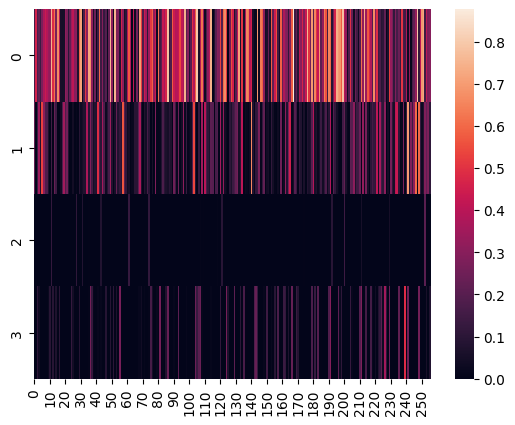

In [12]:
sns.heatmap(global_ratio)